In [1]:
# imports tons of things I will need for calculations
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from statistics import mean
import random
import math
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from torchvision import datasets, transforms
from PIL import Image
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
labelsMap = {}
outputMap = {}
def loadFiles(directory):
    imgs = []
    labs = []
    count = 0
    for f in directory:
        if f.endswith(".npy"):
            #print(file)
            file = "./files/" + f
            x = np.load(file)
            x = x.astype('float32') / 255.
            y = [count for _ in range(10000)]
            y = np.array(y).astype('float32')
            y = y.reshape(y.shape[0], 1)
            label = f[:-4]
            labelsMap[label] = count
            outputMap[count] = label
            labs.append(y)
            x = x[0:10000, :]
            imgs.append(x)
            count += 1
    return imgs, labs

images, labels = loadFiles(os.listdir('./files/'))
print(labelsMap)
print(outputMap)

{'airplane': 0, 'foot': 1, 'banana': 2, 'bus': 3, 'bush': 4, 'ambulance': 5, 'helicopter': 6, 'backpack': 7, 'alarm clock': 8, 'aircraft carrier': 9}
{0: 'airplane', 1: 'foot', 2: 'banana', 3: 'bus', 4: 'bush', 5: 'ambulance', 6: 'helicopter', 7: 'backpack', 8: 'alarm clock', 9: 'aircraft carrier'}


In [3]:
def showImage(img):
    i = img.reshape((28, 28))
    plt.imshow(i, cmap="Greys")
    plt.show()

In [4]:
def getTrainandTest(imgs, labs):
    train_imgs = []
    test_imgs = []
    train_labs = []
    test_labs = []

    for i in range(len(imgs)):
        test_imgs.append(imgs[i][0:1000])
        test_labs.append(labs[i][0:1000])
        train_imgs.append(imgs[i][1000:])
        train_labs.append(labs[i][1000:])
    return train_imgs, train_labs, test_imgs, test_labs
trainImgs, trainLabs, testImgs, testLabs = getTrainandTest(images, labels)
print(len(trainImgs[0]))

9000


In [6]:
def combineImages(imgs, labs):
    newImages = imgs[0]
    newLabels = labs[0]
    for i in range(1, len(imgs)):
        newImages = np.concatenate((newImages, imgs[i]), axis=0)
        newLabels = np.concatenate((newLabels, labs[i]), axis=0)
    return newImages, newLabels
img_train, lab_train = combineImages(trainImgs, trainLabs)
img_test, lab_test = combineImages(testImgs, testLabs) 


In [7]:
trainImgs_list = img_train.tolist()
trainLabel_list = lab_train.tolist()
testImgs_list = img_test.tolist()
testLabel_list = lab_test.tolist()

In [8]:
def fixLabels(labs):
    # is of size N labels by 1
    # turning into size N
    newLabs = []
    for i in range(len(labs)):
        newLabs.append(labs[i][0])
    return newLabs
trainLabel_list_correct = fixLabels(trainLabel_list)
testLabel_list_correct = fixLabels(testLabel_list)

In [10]:
def batchANDrandom(images, labels, batchSize):
    indeces = []
    for i in range(len(images)):
        indeces.append(i)
    
    img = []
    lab = []
    for i in range(len(images)//batchSize):
        newImgs = []
        newLab = []
        for j in range(batchSize):
            index = random.randint(0, len(indeces)-1)
            val = indeces[index]
            indeces.pop(index)
            
            newImgs.append(images[val])
            newLab.append(labels[val])
        
        img.append(newImgs)
        lab.append(newLab)
    return img, lab
b_img_train, b_lab_train = batchANDrandom(trainImgs_list, trainLabel_list_correct, 64)
b_img_test, b_lab_test = batchANDrandom(testImgs_list, testLabel_list_correct, 64)

In [11]:
# convert to tensor
def tensorize(arr):
    nump = np.array(arr)
    tens = torch.tensor(nump)
    return tens

b_img_train = tensorize(b_img_train)
b_lab_train = tensorize(b_lab_train)
b_img_test = tensorize(b_img_test)
b_lab_test = tensorize(b_lab_test)

In [12]:
# images of type float
# labels of type long
imgTrain = b_img_train.float()
labTrain = b_lab_train.long()
imgTest = b_img_test.float()
labTest = b_lab_test.long()

In [13]:
# Building Network  
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 100)
        self.fc5 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc3(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc4(x))
        x = F.dropout(x, training=self.training)
        x = self.fc5(x)
        return F.log_softmax(x, dim=1)

In [15]:
# PREPARING Dataset

n_epochs = 20 # how many times we'll loop through training data
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01 # hyperparameter
momentum = 0.5 # hyperparameter
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [16]:
# Training model
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(imgTrain) for i in range(n_epochs + 1)] # this is [0, 60000, 12000, 18000]

In [17]:
def train(epoch):
    network.train()
    for batch in range(len(imgTrain)):
        optimizer.zero_grad()
        temp = imgTrain[batch]
        temp = temp.reshape(64, 1, 28, 28)
        output = network(temp)
        loss = F.nll_loss(output, labTrain[batch])
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_counter.append(
            (batch + 1) * len(imgTrain[batch]))
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, (batch + 1) * len(imgTrain[batch]), len(imgTrain[batch]),
            100. * (batch + 1) / len(imgTrain), loss.item()))

In [18]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch in range(len(imgTest)):
            temp = imgTest[batch]
            temp = temp.reshape(64, 1, 28, 28)
            output = network(temp)
            test_loss += F.nll_loss(output, labTest[batch], size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(labTest[batch].data.view_as(pred)).sum()

        test_loss /= len(labTest)
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, (len(labTest) * 64),
            100. * correct / (len(labTest) * 64)))

In [19]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/Users/betinakreiman/opt/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 147.5018, Accuracy: 999/9984 (10%)

Train Epoch: 1 [64/64 (0%)]	Loss: 2.300550
Train Epoch: 1 [128/64 (0%)]	Loss: 2.296950
Train Epoch: 1 [192/64 (0%)]	Loss: 2.292011
Train Epoch: 1 [256/64 (0%)]	Loss: 2.307528
Train Epoch: 1 [320/64 (0%)]	Loss: 2.301140
Train Epoch: 1 [384/64 (0%)]	Loss: 2.292143
Train Epoch: 1 [448/64 (0%)]	Loss: 2.308856
Train Epoch: 1 [512/64 (1%)]	Loss: 2.305248
Train Epoch: 1 [576/64 (1%)]	Loss: 2.317665
Train Epoch: 1 [640/64 (1%)]	Loss: 2.297160
Train Epoch: 1 [704/64 (1%)]	Loss: 2.309603
Train Epoch: 1 [768/64 (1%)]	Loss: 2.306765
Train Epoch: 1 [832/64 (1%)]	Loss: 2.299925
Train Epoch: 1 [896/64 (1%)]	Loss: 2.297051
Train Epoch: 1 [960/64 (1%)]	Loss: 2.301234
Train Epoch: 1 [1024/64 (1%)]	Loss: 2.287450
Train Epoch: 1 [1088/64 (1%)]	Loss: 2.305281
Train Epoch: 1 [1152/64 (1%)]	Loss: 2.318344
Train Epoch: 1 [1216/64 (1%)]	Loss: 2.305691
Train Epoch: 1 [1280/64 (1%)]	Loss: 2.303290
Train Epoch: 1 [1344/64 (1%)]	Loss: 2.311665
Train Epoch: 

In [20]:
def predictingImage(img):
    img = img.reshape(1, 1, 28, 28)
    img = img.float()
    output = network(img)
    return output.data.max(1, keepdim=True)[1][0].item()
predictingImage(imgTrain[0][0])

9

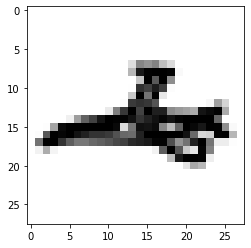

tensor(9) aircraft carrier


In [24]:
showImage(imgTrain[0][0])
print(labTrain[0][0], outputMap[9])

([-0.08917304873466492, -2.466794729232788, -8.155811309814453, -8.777983665466309, -11.204026222229004, -13.897295951843262, -14.487151145935059, -16.210491180419922, -18.063426971435547, -24.58511734008789], [5, 3, 8, 4, 9, 6, 7, 0, 1, 2])


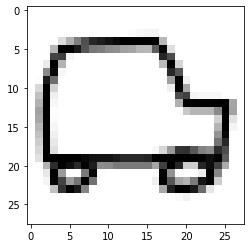

In [25]:
def predictingOutput(img):
    img = img.reshape(1, 1, 28, 28)
    img = img.float()
    output = network(img)
    outputs = []

    for i in range(10):
        outputs.append(output.data[0][i].item())
    return outputs
predictingOutput(imgTrain[0][3])

def rearrangeOutput(probabilities):
    #indeces = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    newProb = []
    numbers = []
    temp = probabilities
    minimum = min(probabilities) - 1
    for i in range(len(probabilities)):
        x = temp.index(max(temp))
        newProb.append(temp[x])
        temp[x] = minimum
        numbers.append(x)
    return newProb, numbers
imageTesting = imgTrain[0][3]
print(rearrangeOutput(predictingOutput(imageTesting)))
showImage(imageTesting)


In [28]:
# save for IOS Format

import torch
import torchvision
from torch.utils.mobile_optimizer import optimize_for_mobile
modelForIos = network
modelForIos.eval()
example = torch.rand(1, 1, 28, 28)
traced_script_module = torch.jit.trace(modelForIos, example)
torchscript_model_optimized = optimize_for_mobile(traced_script_module)
torchscript_model_optimized._save_for_lite_interpreter("../model/googleModel.pt")